## TS Data Challenge
**Data analysis:**
- Which station has the most number of units?
- What is the total number of entries & exits across the subway system for February 1, 2013?
- Let’s define the busy-ness as sum of entry & exit count. What station was the busiest on February 1, 2013? What turnstile was the busiest on that date?
- What stations have seen the most usage growth/decline in 2013?
- What dates are the least busy? Could you identify days on which stations were not operating at full capacity or closed entirely?
- Bonus:  What hour is the busiest for station CANAL ST in Q1 2013?

**Visualization:**
- Plot the daily row counts for data files in Q1 2013.
- Plot the daily total number of entries & exits across the system for Q1 2013.
- Plot the mean and standard deviation of the daily total number of entries & exits for each month in Q1 2013 for station 34 ST-PENN STA.
- Plot 25/50/75 percentile of the daily total number of entries & exits for each month in Q1 2013 for station 34 ST-PENN STA.
- Plot the daily number of closed stations and number of stations that were not operating at full capacity in Q1 2013.


**Resources**  
MTA Turnstile Records live [here](http://web.mta.info/developers/turnstile.html)  
Data schema for files prior to Oct. 2014 live [here](http://web.mta.info/developers/resources/nyct/turnstile/ts_Field_Description_pre-10-18-2014.txt)  
Crosswalk for Remote/Booths lives [here](http://web.mta.info/developers/resources/nyct/turnstile/Remote-Booth-Station.xls)

**Notes**  
The MTA has data has stations with the same name on different divisions and lines; for the sake of this exercise, we will assume that all stations with the same name are one station.

## Pre-processing

In [1]:
import pandas as pd
import requests
import statistics
import os
import csv
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
import collections
from datetime import timedelta
from collections import defaultdict

In [2]:
#Define directory to download files
os.chdir('/Users/ClyneKP/Documents/TS_DataScienceChallenge')

"""
MTA Turnstile File Convention: "turnsile_YYMMDD.txt" ex. "turnstile_130223.txt"
Files dates are Saturdays and encompass the prior week, ex. 130223 includes data for Feb 16 - Feb 22
"""

base_url = 'http://web.mta.info/developers/data/nyct/turnstile/'

#First file of 2013 is 01/05/2013
start = datetime.datetime.strptime("01-05-2013", "%m-%d-%Y")

'''
Since we're not starting on the 1st of the month, to capture every day in 2013, we'll need 53 weeks of data
Make a loop to create a list of filenames we'll need
'''
files = []
for i in range(53):
    files.append((start + timedelta(days=i*7)).strftime("turnstile_%y%m%d.txt"))

#Load in remote/booth crosswalk
crosswalk = pd.read_excel('http://web.mta.info/developers/resources/nyct/turnstile/Remote-Booth-Station.xls').values.tolist()

#Make a dictionary of station names
station_dict = {}
for row in crosswalk:
    station_dict.setdefault(tuple(row[:2]), []).append(row[2:])

In [3]:
"""
In each file, there are usually (but annoyingly, not always) eight 'audits' included in each record. 
This spills over into multiple date ranges.
We should flatten these so each audit has it's own record making it easier to search

Define a function so that python accesses an append function as a local variable. 
"""
def flatten_mta(df):
    newdata = []
    #To speed up processing, define the append here so function references aren't reevaluated each loop
    append = newdata.append
    for i in range(len(df)):
        """
        The first 3 values in each record identify the turnstile, the remaining are individual audits
        Each audit has 5 values; 
        Make a list of the first index position for each of the audits depending on the length of the record
        
        Function should use our index of audit positions and concatenate with remote identifiers into a new record;
        append record to a new empty list.
        """  
        audit_index = np.arange(3, len(df[i]), 5).tolist()
        for t in audit_index:
            """
            Look up station name in dictionary, since this likely isn't a 2013 crosswalk, 
            if it doesn't exist, flag as unknown
            """
            try:
                station_name = station_dict[(df[i][1]),(df[i][0])][0]
            except KeyError:
                station_name = ['Unknown','Unknown','Unknown']
            audit = df[i][0:3] + station_name + df[i][t:t+5]
            append(audit)
    return newdata

In [ ]:
#Download all required files to our directory
for file in files:
    url = base_url + file
    r = requests.get(url, allow_redirects=True)
    open(file, 'wb').write(r.content)

In [4]:
#Make a master list to join all files together
master_list = []
for i in range(len(files)):
    with open(files[i]) as f:
        reader = csv.reader((line.replace('\0','') for line in f), delimiter=",")
        rows = [[cell.strip() for cell in row] for row in reader]
        flat_rows = flatten_mta(rows)
        master_list = master_list + flat_rows

In [5]:
raw_audits = {}
for row in master_list:
    raw_audits.setdefault(tuple(row[:4]), []).append(tuple(row[4:]))
    
'''
In the raw data, in addition to the regular audits, there are additional audit events that may impact the data
such as hardware failure and manual entries.
Filter the data to select for only the regular events
'''

regular_audits = {station: [(line, division, date, time, desc, entries, exits) for (line, division, date, time, desc, entries, exits) in rows if desc == 'REGULAR']
                   for station, rows in raw_audits.items()}

In [6]:
# Make a dictionary with turnstile ids as keys and cumulative entries and exits as values
datetime_cumulative = {turnstile: [(datetime.datetime.strptime(date + time,'%m-%d-%y%X'),int(entry_cumulative),int(exit_cumulative))
                                   for _, _, date, time, _, entry_cumulative, exit_cumulative in master_list]
                       for turnstile, master_list in regular_audits.items()}

In [7]:
# Check that each row in datetime_cumulative is sorted by increasing date/time.
for row in datetime_cumulative.values():
    assert row == sorted(row,key=lambda x: x[0]), 'Row with unsorted times: "%s"' % row

In [8]:
#Find the delta between times and values to find unique counts within the delta
#Since we'll need it later, create a 'busyness' value for combined entries and exits 
datetime_count_times = {turnstile: [[rows[i][0], rows[i+1][0] - rows[i][0], rows[i+1][1] - rows[i][1],rows[i+1][2] - rows[i][2],(rows[i+1][1] - rows[i][1]+rows[i+1][2] - rows[i][2])]
                                    for i in range(len(rows) - 1)]
                        for turnstile, rows in datetime_cumulative.items()}

#There is a slight bit of noise in the data when counters reset; 
#for ease let's remove count values less than 0 and greater than 15000, since those are impossible
datetime_counts = {turnstile: [(time, entry_count, exit_count, total_count) for (time, _, entry_count, exit_count, total_count) in rows if 0 <= total_count <= 30000]
                   for turnstile, rows in datetime_count_times.items()}

#Find monthly counts for all turnstiles
day_counts = {}
for turnstile, rows in datetime_counts.items():
    entries_by_day = {}
    exits_by_day = {}
    total_by_day = {}
    for time, entry_count, exit_count, total_count in rows:
        day = time.date()
        entries_by_day[day] = entries_by_day.get(day, 0) + entry_count
        exits_by_day[day] = exits_by_day.get(day, 0) + exit_count
        total_by_day[day] = total_by_day.get(day, 0) + total_count
    day_counts[turnstile] = [sorted(entries_by_day.items()),sorted(exits_by_day.items()),sorted(total_by_day.items())]



## Analysis 

#### Which station has the most number of units?

In [9]:
'''
Since there aren't that many units within each station...
I'm going to assuming 'unit' here actually refers to turnstiles which is represented in the data as SCP.
Group units by station and SCP; creating a unique id for each 'unit' with Control Area, Unit, and SCP
'''
stations_byname = {}
for turnstile in datetime_counts.keys():
    units   = turnstile[0] + turnstile[1] + turnstile[2]
    stname = turnstile[3]
    stations_byname.setdefault(stname,set()).add(units)

#Count the number of units in each station
unit_counts = {}
for stname,units in stations_byname.items():
    station_name = stname
    count = len(units)
    unit_counts.setdefault(station_name,count)

#Sort the list
sort_units = sorted(unit_counts.items(), key=lambda x: x[1], reverse=True)
print('The station with the most units is %s with %s units.' %(sort_units[0][0],sort_units[0][1]))


The station with the most units is 34 ST-PENN STA with 100 units.


#### What is the total number of entries & exits across the subway system for February 1, 2013?

In [10]:
#What is the total number of entries & exits across the subway system for February 1, 2013?
feb_one_entries = {station: [(time, count) for (time, count) in rows[0] if (time.month == 2) & (time.day == 1)]
                   for station, rows in list(day_counts.items())}

feb_one_exits = {station: [(time, count) for (time, count) in rows[1] if (time.month == 2) & (time.day == 1)]
                   for station, rows in list(day_counts.items())}


n_entries = {station: sum(x[1] for x in rows) for station,rows in feb_one_entries.items()}
entries = sum(n_entries.values())

n_exits = {station: sum(x[1] for x in rows) for station,rows in feb_one_exits.items()}
exits = sum(n_exits.values())


print('On Feb. 1, 2013 there were %s entries and %s exits.' %(format(entries, ","),format(exits,",")))


On Feb. 1, 2013 there were 5,902,642 entries and 4,567,676 exits.


#### Let’s define the busy-ness as sum of entry & exit count. What station was the busiest on February 1, 2013?  What turnstile was the busiest on that date?

In [11]:
#Make daily counts for total entries + exits for each station
station_day_counts = {}
for turnstile,rows in day_counts.items():
    station = turnstile[3]
    station_day_counts.setdefault(station,{})
    for day,count in rows[2]:
        station_day_counts[station][day] = station_day_counts[station].get(day,0) + count
for station,rows in station_day_counts.items():
    station_day_counts[station] = sorted(rows.items())

#Filter for Feb 1
total_feb_one = {station: [(time, count) for (time, count) in rows if (time.month == 2) & (time.day == 1)]
                   for station, rows in station_day_counts.items()}

#Sort the list
sort_total = sorted(total_feb_one.items(), key=lambda x: x[1], reverse=True)
print('On Feb.1, 2013, the busiest station was %s with %s combined entries and exits.' %(sort_total[0][0],format(sort_total[0][1][0][1],",")))

##What turnstile was the busiest on that date?
turnstile_total_feb_one = {station: [(time, count) for (time, count) in rows[2] if (time.month == 2) & (time.day == 1)]
                   for station, rows in day_counts.items()}

sort_turnstile = sorted(turnstile_total_feb_one.items(), key=lambda x:x[1], reverse=True)
sort_turnstile[1]
print('\nOn Feb.1, 2013, the busiest turnstile was Device %s at Booth %s in Control Area %s in %s \n with %s combined entries and exits.' %(sort_turnstile[0][0][2], sort_turnstile[0][0][1], sort_turnstile[0][0][0], sort_turnstile[0][0][3], format(sort_turnstile[0][1][0][1],",")))

On Feb.1, 2013, the busiest station was 34 ST-PENN STA with 351,273 combined entries and exits.

On Feb.1, 2013, the busiest turnstile was Device 00-00-00 at Booth R047 in Control Area R240 in 42 ST-GRD CNTRL 
 with 13,474 combined entries and exits.


#### What stations have seen the most usage growth/decline in 2013?

In [ ]:
'''
For the sake of this assignment, let's define growth and decline as the greatest percent change in average monthly volume
Given seasonal changes in station usage, we will need historial data to compare. Let's use 2012.
'''

#Repeat our data download and cleaning process for 2012
start_12 = datetime.datetime.strptime("01-07-2012", "%m-%d-%Y")
files_12 = []
for i in range(53):
    files_12.append((start_12 + timedelta(days=i*7)).strftime("turnstile_%y%m%d.txt"))

for file in files_12:
    url = base_url + file
    r = requests.get(url, allow_redirects=True)
    open(file, 'wb').write(r.content)
    
master_list_12 = []
for i in range(len(files_12)):
    with open(files_12[i]) as f:
        reader = csv.reader((line.replace('\0','') for line in f), delimiter=",")
        rows = [[cell.strip() for cell in row] for row in reader]
        flat_rows = flatten_mta(rows)
        master_list_12 = master_list_12 + flat_rows

In [13]:
#The 2012 data has some audits with incomplete entries, so we'll filter them out
complete_audits = [x for x in master_list_12 if len(x) == 11]
regular_audits = [x for x in complete_audits if x[8] == 'REGULAR']

In [14]:
#Make a dictionary of units
raw_audits_12 = {}
for row in regular_audits:
    raw_audits_12.setdefault(tuple(row[:4]), []).append(tuple(row[4:]))

# Make a dictionary with turnstile ids as keys and cumulative entries and exits as values
datetime_cumulative_12 = {turnstile: [(datetime.datetime.strptime(date + time,'%m-%d-%y%X'),int(entry_cumulative),int(exit_cumulative))
                                   for _, _, date, time, _, entry_cumulative, exit_cumulative in master_list_12]
                       for turnstile, master_list_12 in raw_audits_12.items()}

#Find the delta between times and values to find unique counts within the delta
#Since we'll need it later, create a 'busyness' value for combined entries and exits 
datetime_count_times_12 = {turnstile: [[rows[i][0], rows[i+1][0] - rows[i][0], rows[i+1][1] - rows[i][1],rows[i+1][2] - rows[i][2],(rows[i+1][1] - rows[i][1]+rows[i+1][2] - rows[i][2])]
                                    for i in range(len(rows) - 1)]
                        for turnstile, rows in datetime_cumulative_12.items()}

#There is a slight bit of noise in the data when counters reset; 
#for ease let's remove count values less than 0 and greater than 15000, since those are impossible.
datetime_counts_12 = {turnstile: [(time, entry_count, exit_count, total_count) for (time, _, entry_count, exit_count, total_count) in rows if 0 <= entry_count <= 15000 or 0 <= exit_count <= 15000]
                   for turnstile, rows in datetime_count_times_12.items()}

#Find monthly counts for all turnstiles
month_counts_12 = {}
for turnstile, rows in datetime_counts_12.items():
    total_by_month = {}
    for time, entry_count, exit_count, total_count in rows:
        month = time.month
        total_by_month[month] = total_by_month.get(month, 0) + total_count
    month_counts_12[turnstile] = sorted(total_by_month.items())

#Group by station
station_month_counts_12 = {}
for turnstile,rows in month_counts_12.items():
    station = turnstile[3]
    station_month_counts_12.setdefault(station,{})
    for month,count in rows:
        station_month_counts_12[station][month] = station_month_counts_12[station].get(month,0) + count

#Find the monthly average for each station in 2012
station_monthly_average_12 = {}
for d in station_month_counts_12.items():
    station = d[0]
    average = int(statistics.mean(d[1].values()))
    station_monthly_average_12.setdefault(station,average)

In [15]:
#Repeat monthly processing for 2013 data
month_counts_13 = {}
for turnstile, rows in datetime_counts.items():
    total_by_month = {}
    for time, entry_count, exit_count, total_count in rows:
        month = time.month
        total_by_month[month] = total_by_month.get(month, 0) + total_count
    month_counts_13[turnstile] = sorted(total_by_month.items())

#Group by station
station_month_counts_13 = {}
for turnstile,rows in month_counts_13.items():
    station = turnstile[3]
    station_month_counts_13.setdefault(station,{})
    for month,count in rows:
        station_month_counts_13[station][month] = station_month_counts_13[station].get(month,0) + count
    
#Find the monthly average for each station in 2013
station_monthly_average_13 = {}
for d in station_month_counts_13.items():
    station = d[0]
    average = int(statistics.mean(d[1].values()))
    station_monthly_average_13.setdefault(station,average)

In [16]:
#Some stations aren't represented in both data tables, add them to the dictionary with 0 counts 
#e.g. South Ferry which was closed following Hurricane Sandy.
stations = list(pd.DataFrame(crosswalk)[2])
for station in stations:
    if station not in station_monthly_average_12:
        station_monthly_average_12[station] = 0
    if station not in station_monthly_average_13:
        station_monthly_average_13[station] = 0

#Join dicts of averages by key
averages = [station_monthly_average_12, station_monthly_average_13]
joined = {}
for average in station_monthly_average_12.keys():
  joined[average] = tuple(joined[average] for joined in averages)

#Find percent change in monthly averages
monthly_change = {}
for t in joined.items():
    station = t[0]
    #Since we can't have a growth rate from 0 for new/ re-opened stations; 
    #it wouldn't be here inappropriate to change the denominator to 1
    if t[1][0] != 0:
        change = (t[1][1] - t[1][0]) / t[1][0]
    else:
        change = (t[1][1] - t[1][0]) / 1
    monthly_change.setdefault(station,change)

#Sort changes
sort_monthly_change = sorted(monthly_change.items(), key=lambda x:x[1], reverse=True)


print('Between 2012 and 2013 the station with the greatest increase in average monthly ridership was %s \n The station with the greatest decrease was %s.' %(sort_monthly_change[0][0],sort_monthly_change[len(sort_monthly_change)-1][0]))


Between 2012 and 2013 the station with the greatest increase in average monthly ridership was SMITH-9 ST 
 The station with the greatest decrease was THIRTY ST.


#### What dates are the least busy? Could you identify days on which stations were not operating at full capacity or closed entirely?

In [18]:
#Make a list of 2013 dates
s = datetime.datetime.strptime("01-01-2013", "%m-%d-%Y")
days = []
for i in range(365):
    days.append((s + timedelta(days=i+1)).date())


#Group dates together and sum counts
totals = {}
for date in days:
    x = {station: [(count) for (time, count) in rows if time == date]
                   for station, rows in station_day_counts.items()}
    total = 0
    for item in (list(x.values())):
        try:
            total = total + item[0]
        except IndexError:
            pass
    totals.setdefault(date,total)

'''
Christmas, Thanksgiving, and New Years: relatively unsuprising
'''
print('The top 10 least busy days are:')
sorted(totals.items(), key=lambda x: x[1],)[:10]

The top 10 least busy days are:


[(datetime.date(2013, 12, 25), 3334688),
 (datetime.date(2013, 11, 28), 4161847),
 (datetime.date(2013, 1, 27), 4223886),
 (datetime.date(2013, 2, 3), 4261265),
 (datetime.date(2013, 1, 13), 4268263),
 (datetime.date(2013, 1, 6), 4272490),
 (datetime.date(2014, 1, 1), 4359490),
 (datetime.date(2013, 2, 9), 4399412),
 (datetime.date(2013, 2, 24), 4401593),
 (datetime.date(2013, 2, 10), 4458380)]

In [19]:
#To determine under-capacity, let's find the daily average volume for each station. 
#Let's assume under-capacity is when a station sees a daily volume that is less than 25% of average volume
undercapacity = .25

#Count for each day
day_counts_13 = {}
for turnstile, rows in datetime_counts.items():
    total_by_day = {}
    for time, entry_count, exit_count, total_count in rows:
        day = time.date()
        total_by_day[day] = total_by_day.get(day, 0) + total_count
    day_counts_13[turnstile] = sorted(total_by_day.items())

#Group by station
station_day_counts_13 = {}
for turnstile,rows in day_counts_13.items():
    station = turnstile[3]
    station_day_counts_13.setdefault(station,{})
    for day,count in rows:
        station_day_counts_13[station][day] = station_day_counts_13[station].get(day,0) + count
        
#Find the daily average for each station
station_daily_average = {}
for d in station_day_counts_13.items():
    station = d[0]
    average = int(statistics.mean(d[1].values()))
    station_daily_average.setdefault(station,average)


#Make a dict of stations and dates where total counts are under-capacity, zero, or missing values (audits not recorded)
total_dates = {}
merged = defaultdict(list)
for date in days:
    x = {station: [(count) for (time, count) in rows if time == date]
                   for station, rows in station_day_counts.items()}
    
    for item in x:
        try:
            if x[item][0] <= station_daily_average[item]*undercapacity:
                for d in (total_dates, {item: date}):
                    for key, value in d.items():
                        merged[key].append(value)
        except IndexError:
            for d in (total_dates, {item: date}):
                    for key, value in d.items():
                        merged[key].append(value)
            pass

#merged is now a dictionary of dates in which a staion is either closed or saw volume less than 25% of average.
merged

defaultdict(list,
            {'NORWOOD AVE': [datetime.date(2013, 1, 2),
              datetime.date(2013, 1, 3),
              datetime.date(2013, 1, 4),
              datetime.date(2013, 3, 30),
              datetime.date(2013, 3, 31),
              datetime.date(2013, 4, 6),
              datetime.date(2013, 4, 7)],
             'BEACH 90 ST': [datetime.date(2013, 1, 2),
              datetime.date(2013, 1, 3),
              datetime.date(2013, 1, 4),
              datetime.date(2013, 1, 5),
              datetime.date(2013, 1, 6),
              datetime.date(2013, 1, 7),
              datetime.date(2013, 1, 8),
              datetime.date(2013, 1, 9),
              datetime.date(2013, 1, 10),
              datetime.date(2013, 1, 11),
              datetime.date(2013, 1, 12),
              datetime.date(2013, 1, 13),
              datetime.date(2013, 1, 14),
              datetime.date(2013, 1, 15),
              datetime.date(2013, 1, 16),
              datetime.date(2013, 1, 17)

#### What hour is the busiest for station CANAL ST in Q1 2013?

In [20]:
#Filter for Canal
canal = {}
for station, rows in datetime_counts.items():
    if station[3] == 'CANAL ST':
        canal[station] = rows
        
#Group counts by station
canal_counts = {}
for turnstile,rows in canal.items():
    station = turnstile[3]
    canal_counts.setdefault(station,{})
    for time,_,_,count in rows:
        canal_counts[station][time] = canal_counts[station].get(time,0) + count
        
canal_df = pd.DataFrame.from_dict(canal_counts)
#Subset for first quarter
canal_df[(canal_df.index.month-1)//3 == 0]

#Since the audits are in 4 hour intervals; upsample and interpolate to get an hourly count.
canal_resample = canal_df.resample('H').interpolate()
grouped = canal_resample.groupby([canal_resample.index.hour]).sum()
sorted_canal = grouped.sort_values(by=['CANAL ST'], ascending=False).head()

print('The busiest hour for CANAL ST is %s' %(datetime.datetime.strptime(str(sorted_canal.index[0]),'%H').strftime('%I %p')))

The busiest hour for CANAL ST is 05 PM


## Visualization

#### Plot the daily row counts for data files in Q1 2013.

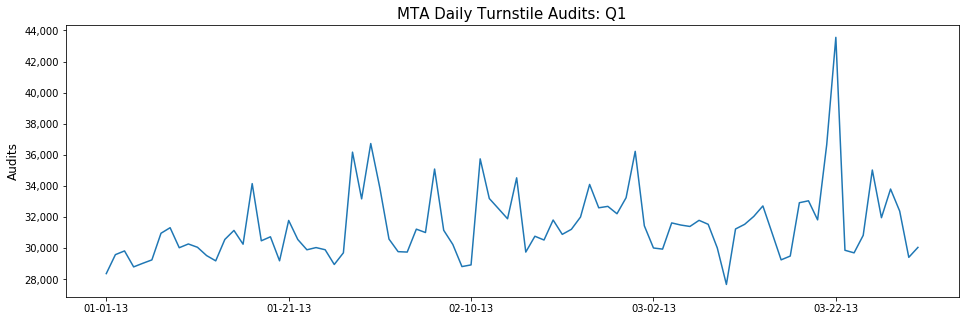

In [21]:
#Since we've isolated each audit into its own row, let's plot those rather than the grouped audits
rows = pd.DataFrame(master_list, columns = ['C/A', 'Unit', 'SCP', 'Station','Line', 'Division', 'Date', 'Time', 'Desc', 'Entries', 'Exits'])
rows['datetime'] = pd.to_datetime(rows['Date'], format='%m-%d-%y', errors='ignore')
q1_rows = rows[((rows['datetime'].dt.month-1)//3 == 0) & (rows['datetime'].dt.year == 2013)]
count_rows = q1_rows.groupby(['Date']).count()

row_days = list(count_rows.index)
row_counts = list(count_rows['Unit'])

fig, axes = plt.subplots( figsize=(16,5) )
axes.plot(row_days,row_counts)
axes.set_ylabel('Audits',fontsize=12)
axes.set_title('MTA Daily Turnstile Audits: Q1',fontsize=15)
axes.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
axes.xaxis.set_major_locator(plt.MaxNLocator(6))

#### Plot the daily total number of entries & exits across the system for Q1 2013.


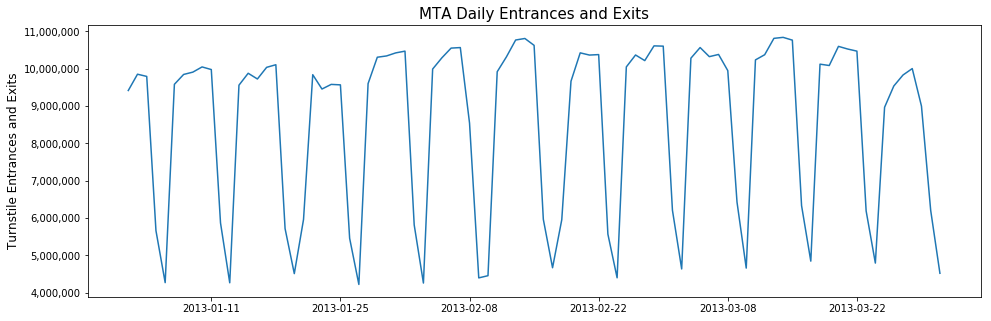

In [22]:
q1 = dict(filter(lambda elem: ((elem[0].month-1)//3 == 0)&(elem[0].year == 2013), totals.items()))

daily_counts = pd.DataFrame.from_records(q1, index=[0])



days = daily_counts.columns
counts = daily_counts.iloc[0].values

fig, axes = plt.subplots( figsize=(16,5) )
axes.plot(days,counts)
axes.set_ylabel('Turnstile Entrances and Exits',fontsize=12)
axes.set_title('MTA Daily Entrances and Exits',fontsize=15)
axes.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

#### Plot the mean and standard deviation of the daily total number of entries & exits for each month in Q1 2013 for station 34 ST-PENN STA.

/Users/ClyneKP/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ClyneKP/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


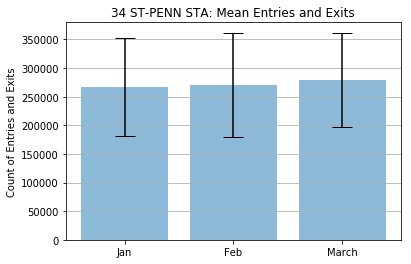

In [23]:
#Filter for Penn Station
penn = {}
for station, rows in datetime_counts.items():
    if station[3] == '34 ST-PENN STA':
        penn[station] = rows
        
#Group counts by station
penn_counts = {}
for turnstile,rows in penn.items():
    station = turnstile[3]
    penn_counts.setdefault(station,{})
    for time,entry,exit,count in rows:
        penn_counts[station][time] = penn_counts[station].get(time,0) + count
        
penn_df = pd.DataFrame.from_dict(penn_counts)
penn_q1 = penn_df[((penn_df.index.month-1)//3 == 0) & (penn_df.index.year == 2013)]
penn_q1['month'] = penn_q1.index.month
penn_q1['day'] = penn_q1.index.day

penn_mean = penn_q1.groupby(['month','day']).sum().groupby(['month']).mean()['34 ST-PENN STA']
penn_std = penn_q1.groupby(['month','day']).sum().groupby(['month']).std()['34 ST-PENN STA']

fig, ax = plt.subplots()
ax.bar(np.arange(len(penn_mean)), penn_mean, yerr=penn_std, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Count of Entries and Exits')
ax.set_xticks(np.arange(len(penn_mean)))
ax.set_xticklabels(['Jan','Feb','March'])
ax.set_title('34 ST-PENN STA: Mean Entries and Exits')
ax.yaxis.grid(True)

#### Plot 25/50/75 percentile of the daily total number of entries & exits for each month in Q1 2013 for station 34 ST-PENN STA.

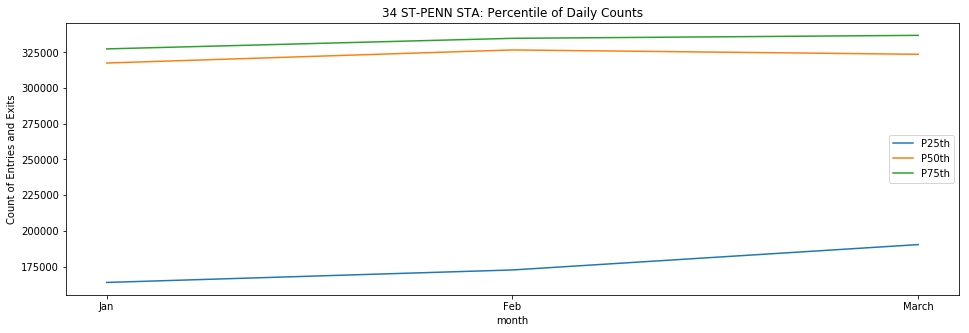

In [24]:
penn_daily = penn_q1.groupby(['month','day']).sum()

P25th = []
P50th = []
P75th = []
for i in range(3):
    P25th.append(np.percentile(penn_daily[penn_daily.index.get_level_values('month') == i+1].sort_values(by=['34 ST-PENN STA'], ascending=False), 25))
    P50th.append(np.percentile(penn_daily[penn_daily.index.get_level_values('month') == i+1].sort_values(by=['34 ST-PENN STA'], ascending=False), 50))
    P75th.append(np.percentile(penn_daily[penn_daily.index.get_level_values('month') == i+1].sort_values(by=['34 ST-PENN STA'], ascending=False), 75))
    
penn_df = {'month':['Jan','Feb','Mar'],'P25th': P25th , 'P50th': P50th, 'P75th': P75th}


pct_df = pd.DataFrame(data=penn_df)

ax = pct_df.plot(figsize=(16,5), x="month", y=["P25th", "P50th", "P75th"])
ax.set_xticks(np.arange(len(penn_mean)))
ax.set_xticklabels(['Jan','Feb','March'])
ax.set_ylabel('Count of Entries and Exits')
ax.set_title('34 ST-PENN STA: Percentile of Daily Counts')
plt.show()


#### Plot the daily number of closed stations and number of stations that were not operating at full capacity in Q1 2013.

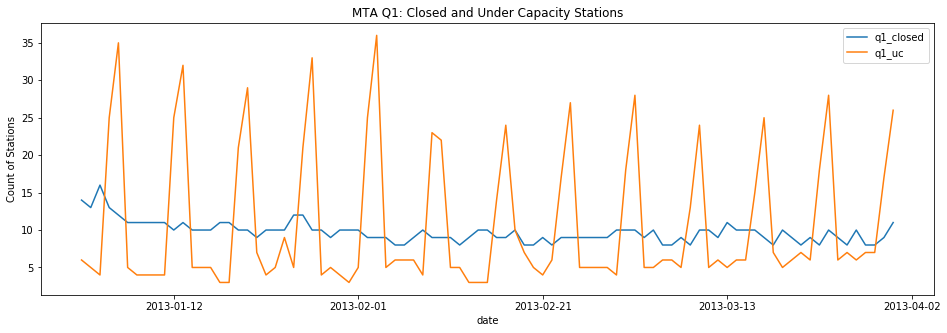

In [27]:
#Make separate dicts for days each station is either closed or under capacity
total_closed = {}
total_uc = {}
merged_closed = defaultdict(list)
merged_uc = defaultdict(list)
for date in days:
    x = {station: [(count) for (time, count) in rows if time == date]
                   for station, rows in station_day_counts.items()}
    for item in x:
        try:
            if (x[item][0] <= station_daily_average[item]*undercapacity) & (x[item][0] > 0) :
                for d in (total_uc, {item: date}):
                    for key, value in d.items():
                        merged_uc[key].append(value)
            if x[item][0] == 0:
                for d in (total_closed, {item: date}):
                    for key, value in d.items():
                        merged_closed[key].append(value)
        except IndexError:
            for d in (total_closed, {item: date}):
                    for key, value in d.items():
                        merged_closed[key].append(value)
            pass

#count the number of stations for each date
closed_count = []
uc_count = []
for date in days:
    for station, rows in merged_closed.items():    
        for i in rows:
            if i == date:
                closed_count.append(i)
    for station, rows in merged_uc.items():    
        for i in rows:
            if i == date:
                uc_count.append(i)

#Convert to df
closed_counter = pd.DataFrame(collections.Counter(closed_count),index=[0])
uc_counter = pd.DataFrame(collections.Counter(uc_count),index=[0])
vertical_stack = pd.concat([closed_counter, uc_counter])
vertical_stack

q1_dates = pd.DataFrame(collections.Counter(closed_count),index=[0]).columns
q1_closed = vertical_stack.iloc[0]
q1_uc = vertical_stack.iloc[1]

closed_dict = {'date':q1_dates,'q1_closed':q1_closed,'q1_uc':q1_uc}
closed_df = pd.DataFrame(data=closed_dict)


'''
For this chart 'closed' includes stations that have 0 recorded audits for that day.
Stations that are 'under-capacity' have between less than 25% of their daily average volume and at least 1 entry or exit.

This looks about right, long term station closures remain relatively consistent while under-capacity stations spike on weekends;
likely due to lower volumes and weekend work.
'''

#Make chart
ax_closed = closed_df.plot(figsize=(16,5), x="date", y=["q1_closed", "q1_uc"])
ax_closed.set_ylabel('Count of Stations')
ax_closed.set_title('MTA Q1: Closed and Under Capacity Stations')
ax_closed.xaxis.set_major_locator(plt.MaxNLocator(6))
plt.show()

